# Assignement - Gender classification on audio files

This notebook contains the codes and explanations for a gender classifier for audio files. Based on [LibriSpeech ASR speech corpus](http://www.openslr.org/12/), features are extracted from the audio files and 4 different Machine learning models are trained in order to build a gender classifier (Man/Woman's voice).

The corpus used in this assignement is the "dev-clean".

## Prerequisites

### Data

The dev-clean [LibriSpeech ASR corpus](http://www.openslr.org/12/).

### Libraries 

* python speech features:  a library used to extract MFCCs features of the audio files. see [github repo](https://github.com/jameslyons/python_speech_features)
```
pip install python_speech_features 
```


* pandas
```
pip install pandas
```

* soundfile
```
pip install soundfile
```

* scikit learn, v > 0.18 required to use MLP neural network

```
pip install scikit-learn==0.18.rc2
```

* TensorFlow is used for the deep learning model

```
pip install tensorflow
```

* Keras is used on top of TensorFlow

```
pip install keras
```



## Data info

Let's first take a look at our data (Number of files, number of speakers, etc...)

In [1]:
import os
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import pandas as pd
import assignement_utils as util
%matplotlib inline

In [2]:
corpus_path = "LibriSpeech/dev-clean/"

# Get the list of speakers ids
speaker_ids = os.listdir(corpus_path)
print("There are {} speakers overall".format(len(speaker_ids)))

# Get the list of chapters for each users
speakerChapters = {}
for speaker in speaker_ids:
    speakerChapters[speaker] = os.listdir("".join([corpus_path, speaker, "/"]))
    
# Get the number of chapters overall
print("There are {} chapters overall".format(sum(map(lambda x: len(speakerChapters[x]), speakerChapters.keys()))))

# Get all unique chapters in the corpus
unique_chapters = set ()
for speaker in speaker_ids:
    unique_chapters = unique_chapters | set(speakerChapters[speaker])
    
print("There are {} unique chapters overall".format(len(unique_chapters)))

# Get the list of files for each users
speakerFiles = {}
allfiles = []
for speaker in speaker_ids:
    for chapter in speakerChapters[speaker]:
        path = "".join([corpus_path, speaker, "/", chapter, "/"])
        files = os.listdir(path)
        speakerFiles[speaker] = list(map(lambda x: path + x, files))
        allfiles += files

# Get files extensions and count occurences
file_ext_occurences = Counter(list(map(lambda x: x.split(".")[-1], allfiles)))
for extension, nb in file_ext_occurences.items():
    print("There are {} {} files".format(nb, extension))

There are 40 speakers overall
There are 97 chapters overall
There are 97 unique chapters overall
There are 2703 flac files
There are 97 txt files


** We notice two intersting things: **
* Each chapter is unique (read by one user only)
* All audio files have "flac" format. 

## Getting gender info on users

Obtain users info from the SPEAKERS.TXT file

In [3]:
users_path = "LibriSpeech/SPEAKERS.TXT"
speakerGender = {}
for line in open(users_path):
    li=line.strip()
    if not li.startswith(";"):
        params = list(map(lambda x: x.strip(), line.split("|")))
        user_id = params[0]
        if user_id in speaker_ids:
            speakerGender[user_id] = params[1]
gender_counter = Counter(map(lambda x: x[1], speakerGender.items()))
print("There are {} female speakers and {} male speakers".format(gender_counter['F'], gender_counter['M']))

There are 20 female speakers and 20 male speakers


## Features extractions

We extract the MFCC features from all audio files using the python_speech_features library.

In [4]:
from python_speech_features import mfcc
from python_speech_features import delta
from python_speech_features import logfbank
import soundfile as sf

# Use the speech features extraction library to get the 13 MFCC features of an audio file
def computeMFCC(audio):
    with open(audio, 'rb') as f:
        sig, rate = sf.read(f)
    mfcc_feat = mfcc(sig,rate)
    return mfcc_feat

**Create a dataframe with for each audio file:**
* The speaker's id
* Its MFCC features
* The gender of the speaker

In [5]:
# Link all audio files with its speaker
all_speaker_audio = []
for speaker in speaker_ids:
    all_speaker_audio += list(map(lambda x: (speaker, x), filter(lambda x: x.split(".")[-1] == "flac", speakerFiles[speaker])))

# Create a dataFrame containing the speakers id, the computed MFCC and the gender of the speaker
'''
UNCOMMENT TO RUN IF YOU DON'T HAVE ALREADY data.json

data = pd.DataFrame(list(map(lambda x: [x[0], computeMFCC(x[1]), speakerGender[x[0]]], all_speaker_audio)))
data.columns = ["speaker", "MFCC", "gender"]
data.to_json("data.json")
'''
# Load the precomputed data
data = pd.read_json("data.json")
# Reform numpy array from json file
data.MFCC = data.MFCC.map(lambda x: np.array(x))

data.sample(5)

,MFCC,gender,speaker
1186,"[[-6.2383823742, -18.8635219279, -18.270203330...",F,3853
864,"[[-36.0436533891, 0.0, -0.0, 0.0, 0.0, 0.0, -0...",F,84
1005,"[[-14.6336357557, -20.9865173612, 2.912248033,...",M,5694
962,"[[-7.0021833623, -18.3489778731, -14.904139816...",F,3576
353,"[[-5.0729576084, -29.3041434386, -22.449185825...",F,1993


## Features analysis

Let's take a look at what the MFCC features look like. We compare an audio file from a female and a male speaker.

This may help to understand what is relevant in those features to classify a woman and a man

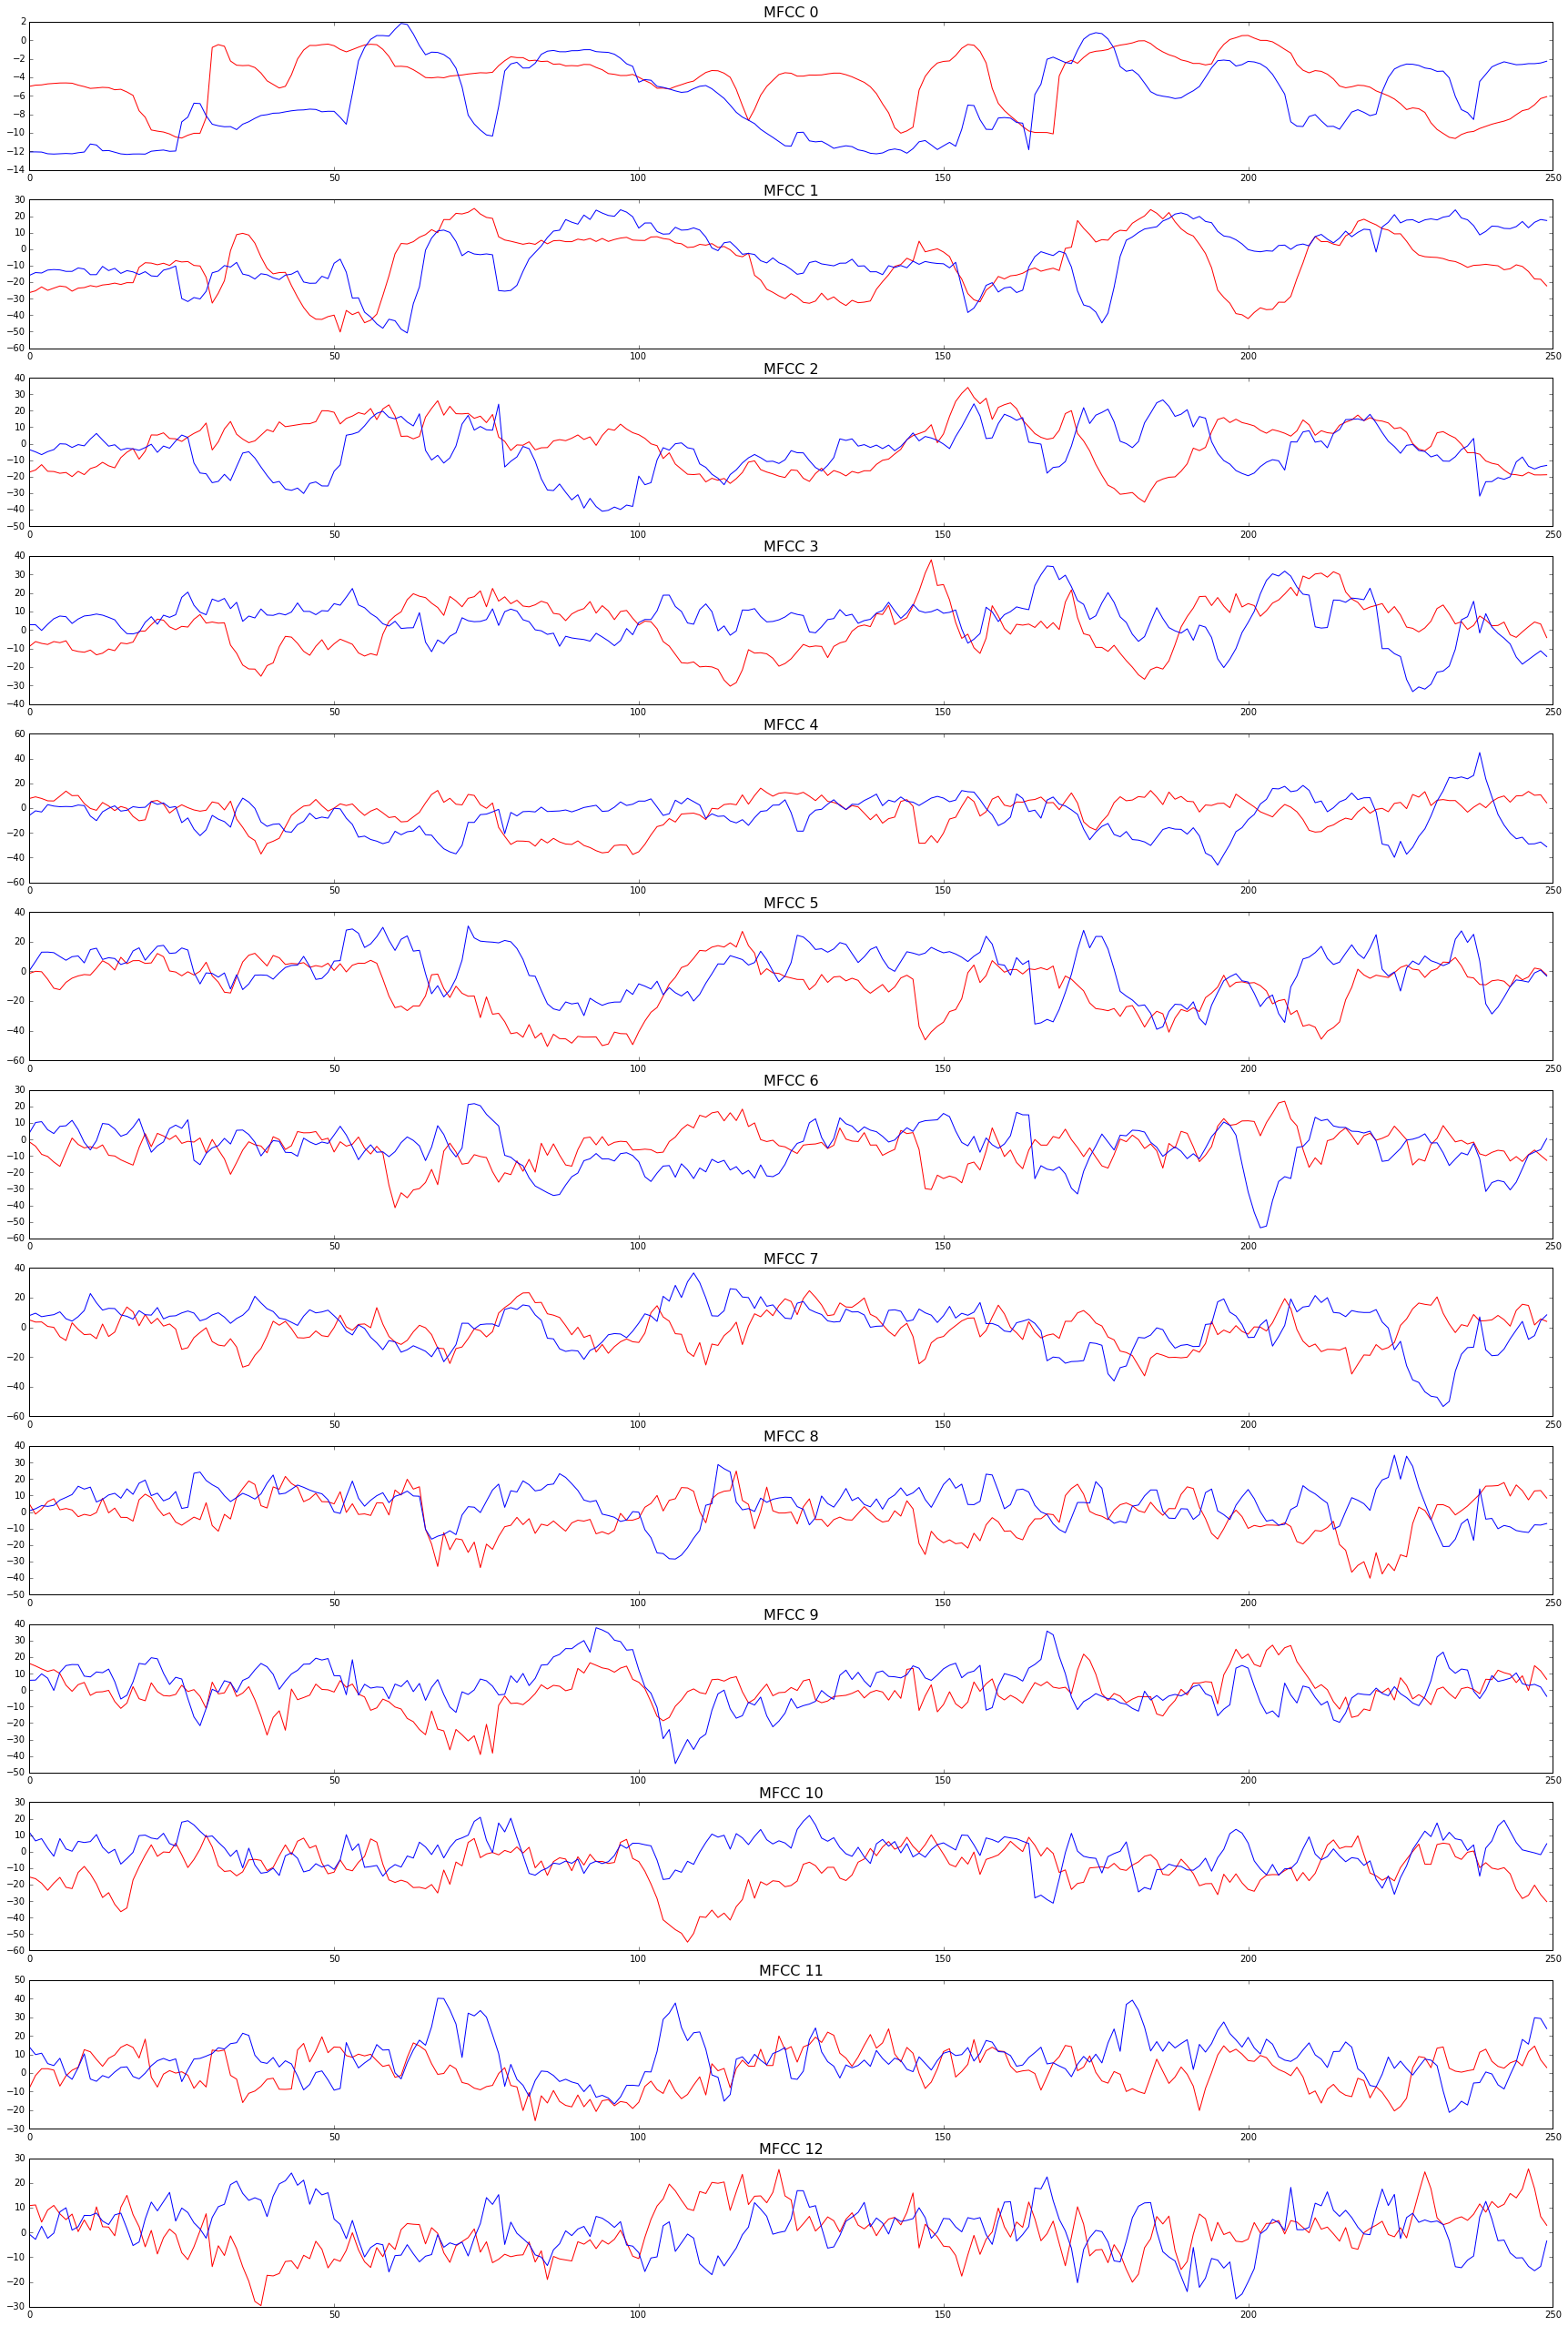

In [6]:
female_MFCC = data[data.gender == 'F'].sample().iloc[0].MFCC
male_MFCC = data[data.gender == 'M'].sample().iloc[0].MFCC

# Plot a temporal graph of the 13 MFCC features over time, for female (red) and male (blue) speakers
fig = plt.figure(1)

for i in range(female_MFCC.shape[1]):
    ax = plt.subplot(female_MFCC.shape[1], 1, i+1)
    ax.set_title("MFCC " + str(i), fontsize=16)
    fline = plt.plot(female_MFCC[:250,i], 'r')
    mline = plt.plot(male_MFCC[:250,i], 'b')
    
fig = plt.gcf()
fig.set_size_inches(30, 45)

We observe that the first MFCC features seems particularyl interesting to differentiate the male and female speaker more than the last ones.

# Features processing



In [7]:
data["Mean"] = data.MFCC.map(lambda x: np.mean(x, axis=0))
data["Std"] = data.MFCC.map(lambda x: np.std(x, axis=0))

## Normalization

In order to build efficient model, it is necessary to process the features. Our 13 MFCC features represents frequency band power, from the lowest-pitch to the highest pitch. 

We expect male speech to have more power than female speech in the low-pitch. In order to build an accurate model it is a good idea to standardize the bands of each audiofile.

In [8]:
data["Mean"] = data["Mean"].map(lambda x: x - np.mean(x))
data["Mean"] = data["Mean"].map(lambda x: x / np.std(x))
data["Std"] = data["Std"].map(lambda x: x - np.mean(x))
data["Std"] = data["Std"].map(lambda x: x / np.std(x))

## Creating training and test sets

### Stats

In [9]:
print("There are {} files audio in total, {} of female speakers and {} of male speakers".format(
        len(data), 
        len(data[data.gender == 'F']),
        len(data[data.gender == 'M'])))

There are 1329 files audio in total, 658 of female speakers and 671 of male speakers


### Splitting

In order to have a relevant train and test set, they must of course be disjoint but we also must ensure that no speaker is present in both the train and the test. Because we expect two different audio files from the same speaker to have correlation in their features, our test set would then not help us to detect overfitting in our models.  

We therefore split the speakers in the test and training set. Since we have 40 speakers (20 female and 20 male), we keep 8 male and 8 female speakers in the test set. This represents 40% of the speakers which is pretty standard for such classification tasks with only 40 different speakers.

In [20]:
female_ids = list(set(data[data.gender == 'F'].speaker))
male_ids = list(set(data[data.gender == 'M'].speaker))

# Select randomly 5 male and 5 female speakers and assign them to the test set
test_ids = list(np.random.choice(female_ids, 8)) + list(np.random.choice(male_ids, 8))
# Assign all other speakers to the train set
train_ids = list(set(data.speaker) - set(test_ids))

# Create train and test audio sets, composed of tuples (audio, gender)
train_data = data[data.speaker.isin(train_ids)].copy()
test_data = data[data.speaker.isin(test_ids)].copy()

We just verify that the audio test set represent a correct ratio (expected around 40% since we selected 40% of the speakers) of the overall data, but it could be more or less because speakers don't have all the same number of audio file.

In [21]:
print("Test set contains %.2f percent of the total audio files" % (100*(len(test_data) / len(all_speaker_audio))))

Test set contains 37.47 percent of the total audio files


# Classification

## Naive classifier

For the naive classifier, I use a Gaussian Naive Bayes model from the sklearn library.

For the naive classifier, for each audio file I use only the mean and standard deviation of the features instead of all the values.

In [47]:
naive_train_features = np.concatenate([np.array(list(train_data.Mean)), np.array(list(train_data.Std))], axis = 1)

In [48]:
naive_test_features = np.concatenate([np.array(list(test_data.Mean)), np.array(list(test_data.Std))], axis = 1)

In [49]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
gnb.fit(naive_train_features, np.array(train_data.gender))
y_pred_train = gnb.predict(naive_train_features)
len(train_data[train_data.gender == y_pred_train]) / len(train_data)

0.9181708784596871

In [50]:
test_data["NaivePreds"] = gnb.predict(naive_test_features)

Compute the accuracy of the naive classifier on the test set

In [51]:
len(test_data[test_data.gender == test_data.NaivePreds]) / len(test_data)

0.8253012048192772

## Random Forest

Let's now use a more sophisticated classifier with a Random Forest. For this classifier, the same features are used (eans and standard deviation of MFCC).



In [52]:
forest_train_features = naive_train_features
forest_test_features = naive_test_features

In [53]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=100,max_depth=12, max_features=0.25)
clf.fit(forest_train_features, np.array(train_data.gender))

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=12, max_features=0.25, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [54]:
y_pred_train = clf.predict(forest_train_features)
len(train_data[train_data.gender == y_pred_train]) / len(train_data)

1.0

Compute the accuracy of the Random Forest classifier on the test set

In [55]:
test_data["RFPreds"] = clf.predict(forest_test_features)
len(test_data[test_data.gender == test_data.RFPreds]) / len(test_data)

0.7931726907630522

## Neural Network

Let's now use a neural network to build a classifier. The model use is a Multi-layer Perceptron (MLP)

In [56]:
mlp_train_features = naive_train_features
mlp_test_features = naive_test_features

In [57]:
from sklearn.neural_network import MLPClassifier

clf = MLPClassifier(solver='adam', alpha=1e-5, hidden_layer_sizes=(50, 50), random_state=1)
clf.fit(mlp_train_features, np.array(train_data.gender))  

MLPClassifier(activation='relu', alpha=1e-05, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(50, 50), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=1, shuffle=True,
       solver='adam', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False)

In [58]:
y_pred_train = clf.predict(forest_train_features)
len(train_data[train_data.gender == y_pred_train]) / len(train_data)

1.0

Compute the accuracy of the MLP classifier on the test set

In [59]:
test_data["MLPPreds"] = clf.predict(mlp_test_features)
len(test_data[test_data.gender == test_data.MLPPreds]) / len(test_data)

0.7931726907630522

## Deep Learning Model

Inspired by the Neural Network design of [this project about gender classification from speech](refs/voice_identification.pdf), I decided to use the same stategies for features input in my model.

This project aim at real-time gender identification on speech, which is not our use-case here, but I found it interesting to have a model capable of such task.

Therefore, I decided to split the array of MFCC features of each audio files into small sequences of **N** MFCC frames, build a model capable of classifying these sequences. Then in order to classify an audio file, we can simply average the classifications of the sequence.

Proceding as such has the advantage of taking into account all MFCC data from our audio files, instead of simply using the mean and std of the files. We can also expect our model, in the sequences where it is hard to tell the gender (like silence) to classify them close to [0.5, 0.5] probability, which will make them not influence the classification during the averaging.

In [24]:
from keras.layers import Input, Dense
from keras.models import Model
from keras.models import load_model
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import LSTM

from keras.utils.np_utils import to_categorical

Using TensorFlow backend.


### Splitting features in sequences of same size

Let's first check the number of MFCC frames in the smallest audio file

In [25]:
print("Smallest audio file contains {} frames".format(min(data.MFCC.map(lambda x: len(x)))))
data[data.MFCC.map(lambda x: len(x)) == 143]

Smallest audio file contains 143 frames


,MFCC,gender,speaker,Mean,Std
508,"[[-9.8491356419, -1.3352572535, 0.4803533935, ...",F,3081,"[-0.846353187939, -1.13038737482, 1.3112253818...","[-1.94591744558, 0.616559587741, 1.0815940103,..."


Chosing our split_size N = 20 seems to be a good sequences lenght to split the files. Our MFCC features represent 25ms each, with step of 10ms between each (15ms overlapping with last frame). 20 frames therefore represents 215ms.

In [26]:
split_size = 20

### Create the train and test dataset and labels

for each audio file, we split the MFCC features into bunch of 20 frames and associate it the gender of the audio file. 

In [27]:
X_train = []
y_train = []

for mfcc, gender in zip(train_data.MFCC, train_data.gender):
    for i in range(int(len(mfcc)/split_size)): 
        X_train.append(mfcc[i*split_size:(i+1)*split_size])
        y_train.append(util.string2int(gender))
        
X_train = np.array(X_train)
y_train = np.array(y_train)

# Convert the label to categorical data
y_train = to_categorical(y_train)

In [28]:
X_test = []
y_test = []

for mfcc, gender in zip(test_data.MFCC, test_data.gender):
    for i in range(int(len(mfcc)/split_size)): 
        X_test.append(mfcc[i*split_size:(i+1)*split_size])
        y_test.append(util.string2int(gender))
        
X_test = np.array(X_test)
y_test = np.array(y_test)
y_test = to_categorical(y_test)

## Build the model

Using Keras framework on top of TensorFlow we can create a quite simple sequence classifier with stacked LSTM.

In [29]:
def buildDNNClassifier(X_train, y_train, batch_size):
    model = Sequential()
    model.add(LSTM(100, return_sequences=True, stateful=True, input_shape=X_train[0].shape,
                   batch_input_shape=(batch_size, X_train.shape[1], X_train.shape[2])))
    model.add(LSTM(100))
    model.add(Dense(2, activation='softmax'))
    model.compile(loss='categorical_crossentropy',
                  optimizer='rmsprop',
                  metrics=['accuracy'])

    # Can train only with multiple of batch size, we therefore ignore the first ones
    ignore_size = len(X_train) % batch_size
    
    model.fit(X_train[ignore_size:], y_train[ignore_size:], batch_size = batch_size)    
    
    
    # Keras uses the same batch size for model training and for predictions. Therefore if we chose a batch_size
    # for predictions that is greater than 1, it will not be possible to classify one frame at a time.
    # I therefrore use a trick to copy the model weight in a new model with batch_size = 1
    old_weights = model.get_weights()
    # re-define model
    model = Sequential()
    model.add(LSTM(100, return_sequences=True, stateful=True, input_shape=X_train[0].shape,
                   batch_input_shape=(1, X_train.shape[1], X_train.shape[2])))
    model.add(LSTM(100))
    model.add(Dense(2, activation='softmax'))
    model.compile(loss='categorical_crossentropy',
                  optimizer='rmsprop',
                  metrics=['accuracy'])
    # copy weights
    model.set_weights(old_weights)
    
    return model

In [39]:
 ''' UNCOMMENT TO RUN THE DNN MODEL TRAINING (Very long with batch_size = 1) '''
#model = buildDNNClassifier(X_train, y_train, 1)

' UNCOMMENT TO RUN THE DNN MODEL TRAINING (Very long with batch_size = 1) '

In [140]:
# model.save('lstm_model_batch1.h5')

In [30]:
# Best results was achieved with a model with batch of size 1
model = load_model('lstm_model_batch1.h5')

### Predictions

We now use the model to classify the whole audio files. We gives the whole MFCC features for each audio file, classify each sequence with the model, and average the classifications to predict the gender for the whole file.

In [32]:
DNNPreds = []
for mfcc in test_data.MFCC:
    DNNPreds.append(util.predictGender(model, mfcc, split_size))

In [34]:
test_data["DNNPreds"] = DNNPreds

We now measure the accuracy of the classification for the whole audio files of the test set.

In [35]:
sum(test_data.DNNPreds == test_data.gender) / len(test_data)

0.99196787148594379

In [36]:
list(test_data.DNNPreds) == list(test_data.gender)

False

We observe that our model performs gender identification on the audio files with 99.2% accuracy.

### Evaluating the performance of single sequence classification

Compute the accuracy of the classifier over the sequences of MFCC frame.

In [37]:
sequences_preds = np.array(model.predict(X_test, batch_size = 1))

In [38]:
test_accuracy = len(list(filter(lambda x: abs(x[0]) < 0.5, y_test - sequences_preds))) / len(y_test)
test_accuracy

0.9297247281980107

Let's now try to evaluate how the classifier works according to the number of sequences it receives for a file.

In [40]:
# Map the audio files to their starting position in the sequences prediction array
start = 0
start_points = [0]
sequences_genders = []

for mfcc,gender in zip(test_data.MFCC, test_data.gender):
    start += int(len(mfcc)/split_size)
    start_points.append(start)
    sequences_genders.append(gender)
    
eg = 87
print("e.g. the prediction of the file {} in our test dataset is located in sequences {} to {}".format(eg, start_points[eg], start_points[eg+1]-1))

e.g. the prediction of the file 87 in our test dataset is located in sequences 3697 to 3703


In [43]:
# Compute the prediction accuracies by using different signals length
# from 1 sequences per audio to maximum 50 sequences in a row per audio
accuracies = []
nb_sequences = list(map(lambda x: int(x), np.linspace(1, 100, 100)))
for nb_sequence in nb_sequences:
    nb_correct = 0
    for i in range(len(test_data)):
        file_sequences_length = start_points[i+1] - start_points[i]
        
        if(file_sequences_length > nb_sequence):
            j = np.random.randint(file_sequences_length-nb_sequence)
            pred = np.sum(sequences_preds[start_points[i]+j:start_points[i]+j+nb_sequence], axis = 0)
        else: 
            pred = np.sum(sequences_preds[start_points[i]+j:start_points[i]+j+file_sequences_length], axis = 0)  

        if(pred[0] > pred[1]):
            if sequences_genders[i] == 'M':
                nb_correct += 1
        else:
            if sequences_genders[i] == 'F':
                nb_correct += 1
    accuracies.append(nb_correct / len(test_data))

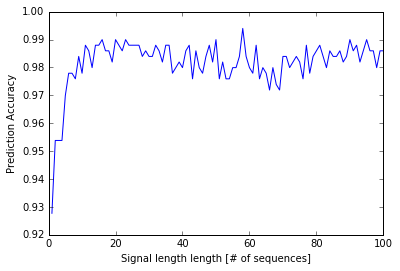

In [44]:
# Display the accuracy vs Signal length graph
plt.plot(nb_sequences, accuracies)

plt.ylabel('Prediction Accuracy')
plt.xlabel('Signal length length [# of sequences]')

We observe that even with 1 sequence (~200ms) analyzed only per audio file, it is enough to achieve 92.9% accuracy. And that with more than 5 sequences (~1 second) in a row, we achieve close to the max accuracy (99.2%).

We could even achieve more accuracy with short signals (< 15 sequences) by first removing the silence part of the audio files. Because they are expected to be difficult to classify.

# Results and discussion

We've now build 4 different models of various complexity.  

The three first models (Bayesian Naive, Random Forest and Multi-Layer Perceptron) were built using the exact same features as input : The mean and standard deviation of each MFCC features for each file.

The last model (A DNN classifier composed of two LSTM layers) was built using all MFCC data of the audio files. The MFCC features have been split into sequences of 20 frames (~200ms of audio), and the model was trained to classify each sequence independently. The classification of an audio file is then computed simply by averaging the classification of each sequences.

In [60]:
accuracies = {}
preds = ["NaivePreds", "RFPreds", "MLPPreds", "DNNPreds"]
for pred in preds:
    accuracies[pred] = sum(test_data[pred] == test_data.gender) / len(test_data)
    
accuracies

{'DNNPreds': 0.99196787148594379,
 'MLPPreds': 0.79317269076305219,
 'NaivePreds': 0.82530120481927716,
 'RFPreds': 0.79317269076305219}

## Comparison of first 3 models

The first 3 models have close accuracies on our test sets.

Surprisingly, the Naive classifier turns out to be the most accurate one. This is due to the actual **short amount of speakers in our dataset (20 men, 20 women)**. With 40% of the speakers in our test set, this represents only 8 women and 8 men. Depending on how the speakers are separated randomly, the accuracies varies strongly. 

What is interesting to say about those three classifiers is that using only the mean and std of the each MFCC feature over an audio file is sufficient to obtain a classifiers with around 80% of accuracy. Those are really simple models and can already performs quite good.

On a much larger dataset, I would expect RandomForset to performs significantly better than the Bayesian Naive for such classification. 

With a better tuning bigger better dataset, I believe the MLP should outperfom the two others.

## Discussion about DNN model

Unlike the 3 previous models, the DNN model was built using all the MFCC data in our train set. This model achieves 97.5% prediction accuracy on our test set, and it has the advantage of being able to classify a sequence of frames instead of the whole audio file.

The model use two LSTM layers (Long Short Term Memory) which performs really good to analyze a sequence. What is impressive with this model is that it can classify a sequence (~200ms) with accuracy of 95.54%. And with a signal of more than 5 sequences (~1s), we achieve the max accuracy on our test sets.

In our case, the DNN model perfoms perfectly, we can't compare it to the three others because it was built using the whole MFCC signals.

But in the end, this kind models is expected to perform way better than simple model, it the best system to be used on such complex task as speech recognition. 